# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
import datetime as dt
import decimal
import time
%matplotlib inline 

### Reading just one file to get started with and analyze the data 

In [56]:
unit = pd.read_csv(r'E:\ds chall\data-science-challenge-master\data\train\unit0000_rms.csv')
alarm = pd.read_csv(r'E:\ds chall\data-science-challenge-master\data\train\unit0000_alarms.csv')

In [57]:

unit.head(15)
alarm.head(5)

,2003-12-15 19:18:56.526325850,warning
0,2003-12-15 23:29:11.344610850,warning
1,2003-12-17 16:26:26.782823329,warning
2,2003-12-18 02:21:51.445540122,warning
3,2004-01-04 17:16:12.501831699,warning
4,2004-01-18 08:44:36.877231277,warning


In [58]:
unit.describe()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


In [59]:
unit.dtypes

timestamp         object
rpm              float64
motor_voltage    float64
motor_current    float64
motor_temp       float64
inlet_temp       float64
dtype: object

In [60]:
# Converting the timestamp to Datetime 
unit.timestamp = pd.to_datetime(unit.timestamp)
unit.set_index('timestamp', inplace=True)

### We will now see the time series plots, box plots and historgrams to see any anomalies or noises or outliers in the data.

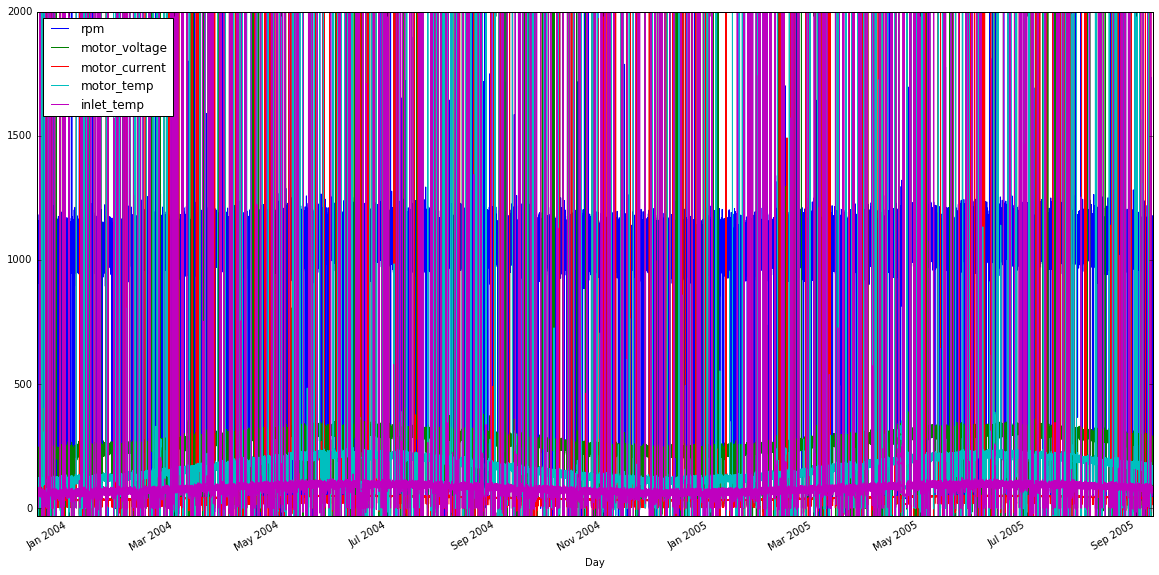

In [61]:
unit.plot(figsize=(20,10), ylim=(-30, 2000))
plt.xlabel('Day', fontsize=10);

### There is a clear evidence of noise in the above time series plot.
### The range 1200-2000 on Y-axis clearly shows noises due to the presence of outliers.

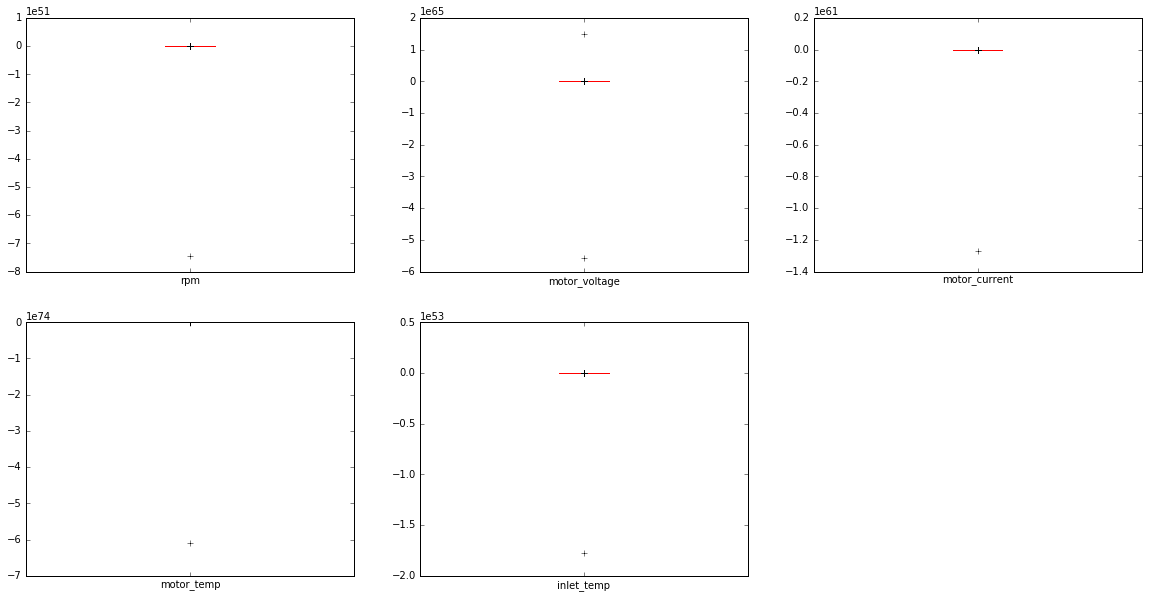

In [62]:
names = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 'inlet_temp']

unit.plot(kind='box', figsize=(20,10), subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

### From the box plots we can see that there are outliers in the data 

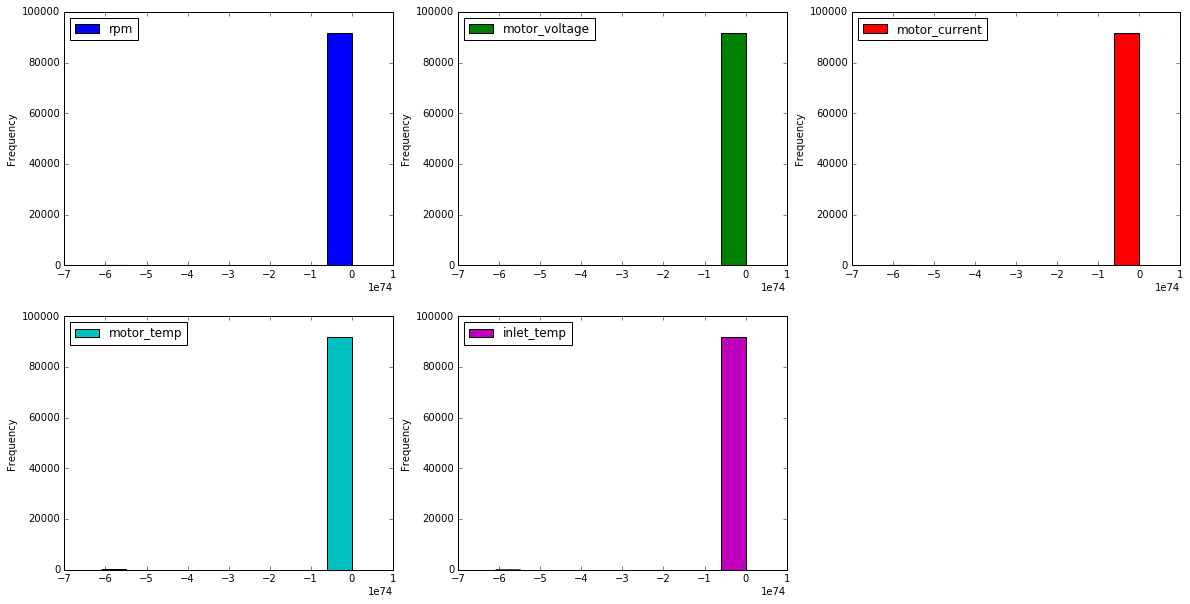

In [63]:
#Plotting histograms of features 
names = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 'inlet_temp']

unit.plot(kind='hist', figsize=(20,10), subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

### The histograms look completely right skewed with very high frequencies due to presence of outliers.
### Removing outliers using percentile cut-off technique. This is one of the method that can be used to remove outliers.


In [64]:

from pandas.api.types import is_numeric_dtype
def clean_rms(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[(df[name] > quant_df.loc[low, name]) & (df[name] < quant_df.loc[high, name])]    
    return df
clean_unit = clean_rms(unit)

### Now lets plot the Time series and see if we get a meaningful plot.


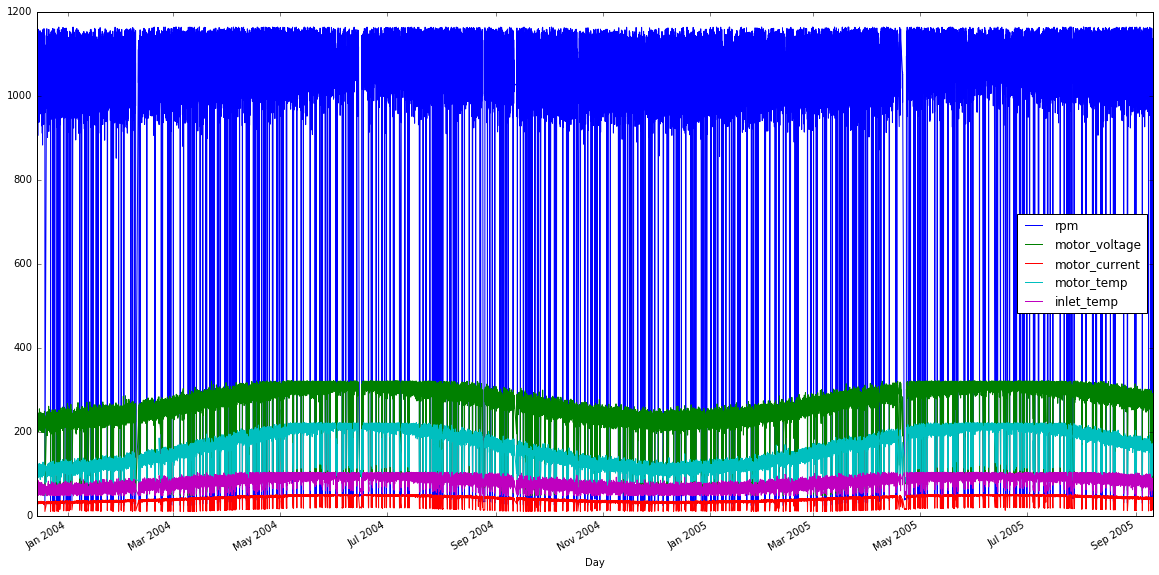

In [65]:
clean_unit.plot(figsize=(20,10)) 
plt.xlabel('Day', fontsize=10)


### Lets see the box plots with this clean data to make sure there are no outliers.

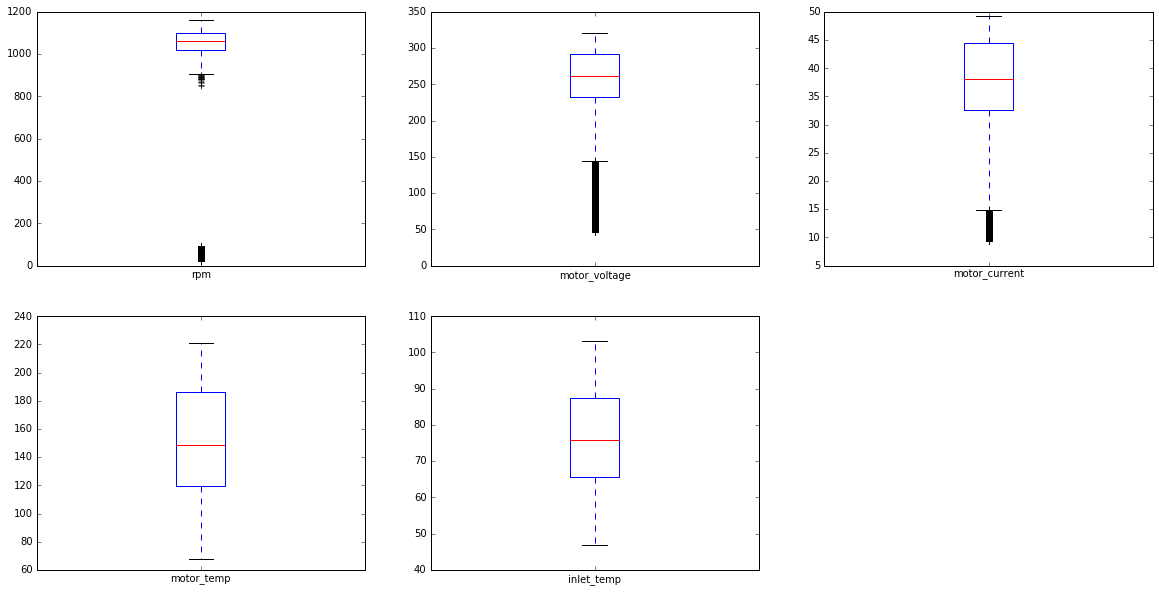

In [68]:
names = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 'inlet_temp']
clean_unit.plot(kind='box', figsize=(20,10), subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

### Now lets see the corelations between the features.

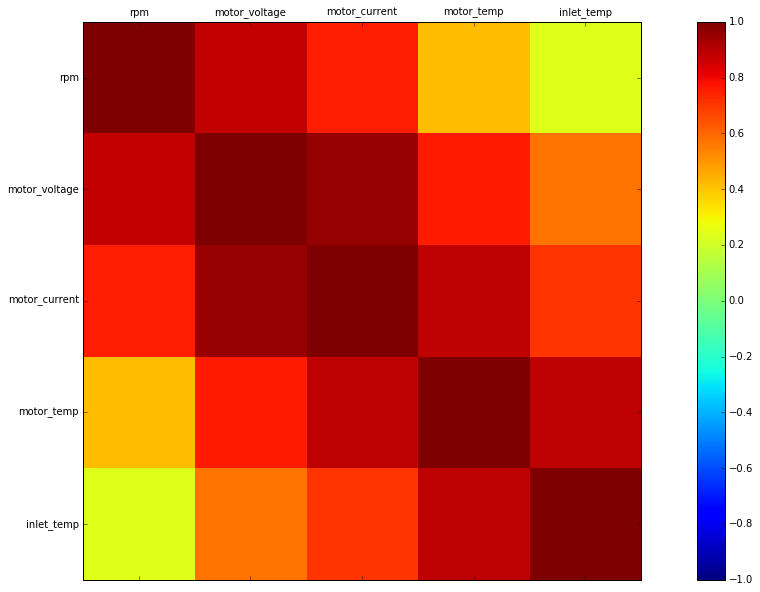

In [70]:
names = ['rpm','motor_voltage','motor_current','motor_temp','inlet_temp']
correlations = clean_unit.corr()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

In [71]:
clean_unit.corr()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
rpm,1.000000,0.878400,0.754315,0.418630,0.242045
motor_voltage,0.878400,1.000000,0.955580,0.762609,0.576390
motor_current,0.754315,0.955580,1.000000,0.886975,0.709613
motor_temp,0.418630,0.762609,0.886975,1.000000,0.889786
inlet_temp,0.242045,0.576390,0.709613,0.889786,1.000000


### As we can see from the above correlation figure that rpm is highly correlated with motor_voltage which is expected, motor_voltage and motor_current are very high correlated accoreding to Ohm's law this is also expected.
### As the motor_temp increases the inlet_temp will also increase. RPM and motor_temp should be highly correlated in my view because as the no of rotations increases naturally the heat in motor will also increase which will increase the temp.
### But they are not highly correlated. the inlet temp and rpm are not hihly correlated which is as expected.

### Lets plot the bar plots to see the frequences of each feature.

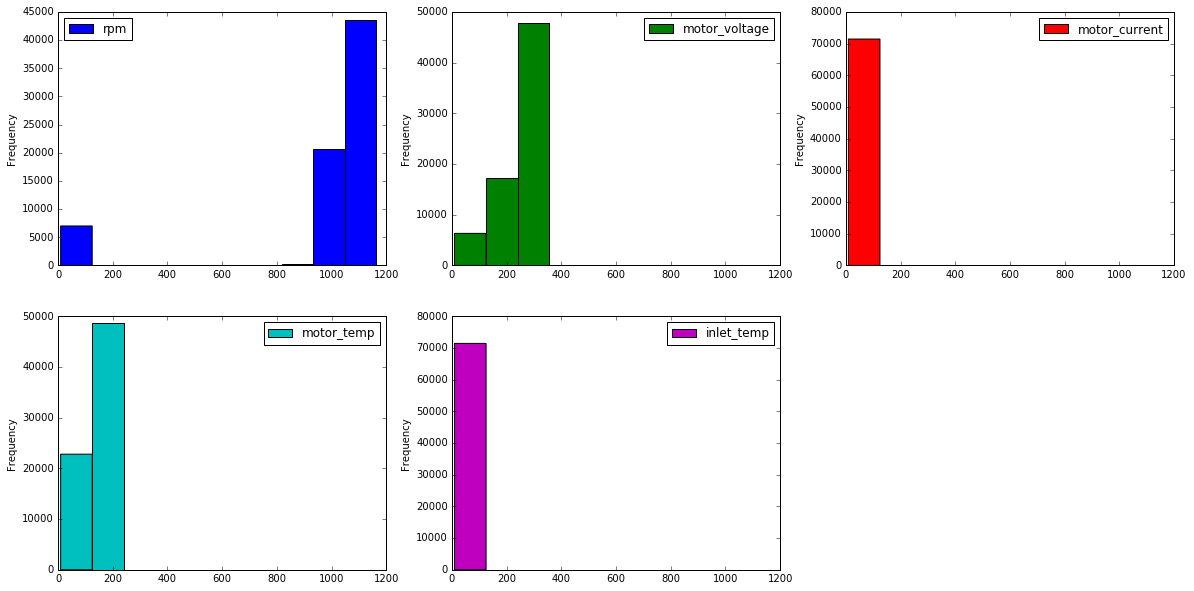

In [73]:
names = ['rpm', 'motor_voltage', 'motor_current', 'motor_temp', 'inlet_temp']

clean_unit.plot(kind='hist', figsize=(20,10), subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()

In [25]:
import datetime as dt
import decimal
import pandas as pd
import os
import numpy as np

alarms_data=pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','train')):
    for file in files:
        if file.endswith("alarms.csv") and os.stat(os.path.join(root, file)).st_size > 0:
            alarms_temp = pd.read_csv(os.path.join(root, file),header=None)
            alarms_temp['unit_id'] = file[4:8]
            alarms_data = alarms_data.append(alarms_temp)
alarms_data.columns = ['timestamp', 'status','unit_id']
alarms_data['unit_id'] = alarms_data['unit_id'].astype('int64')
alarms_data['timestamp'] = alarms_data['timestamp'].str.split('.').str.get(0)
alarms_data['timestamp'] = alarms_data['timestamp'].str.split(':').str.get(0)
alarms_data['timestamp']=alarms_data['timestamp'].str.replace('-','')
alarms_data['timestamp']=alarms_data['timestamp'].str.replace(' ','.')
alarms_data['timestamp'] = alarms_data['timestamp'].astype(np.dtype(decimal.Decimal))

In [26]:
alarms_data.head()

,timestamp,status,unit_id
0,20031215.19,warning,0
1,20031215.23,warning,0
2,20031217.16,warning,0
3,20031218.02,warning,0
4,20040104.17,warning,0


In [27]:
import datetime
import time
rms_data = pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','train')):
    for file in files:
        if file.endswith("_rms.csv"):
            rms_temp = pd.read_csv(os.path.join(root, file))            
            rms_temp =clean_rms(rms_temp)
            rms_temp.index= pd.to_datetime(rms_temp['timestamp'])
            rms_temp.drop(columns=['timestamp'])
            rms_temp=rms_temp.resample('3H').mean()
            rms_temp['unit_id'] = file[4:8]
            rms_data = rms_data.append(rms_temp)

In [28]:
import numpy as np

rms_data.reset_index(inplace=True)
rms_data = rms_data.loc[-rms_data['rpm'].isnull()]
rms_data['unit_id'] = rms_data['unit_id'].astype('int64')
rms_data['timestamp'] = rms_data['timestamp'].astype('str')
rms_data['timestamp'] = rms_data['timestamp'].str.split('.').str.get(0)
rms_data['timestamp']= rms_data['timestamp'].str.split(':').str.get(0)
rms_data['timestamp']=rms_data['timestamp'].str.replace('-','')
rms_data['timestamp']=rms_data['timestamp'].str.replace(' ','.')
rms_data['timestamp'] = rms_data['timestamp'].astype(np.dtype(decimal.Decimal))

rms_data.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id
0,20031214.03,1096.193585,220.192553,30.117273,90.369066,51.702992,0
1,20031214.06,1082.362260,219.513428,29.997431,97.721842,50.609085,0
2,20031214.09,1050.289937,225.737659,30.080688,98.659876,53.011027,0
3,20031214.12,1036.566833,223.248597,30.419686,104.263228,58.730093,0
4,20031214.15,1055.993925,219.674913,30.789283,109.021939,63.503735,0


In [29]:
final_feature = rms_data.merge(alarms_data, on=['timestamp', 'unit_id'], how='left')
#labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
final_feature = final_feature.fillna('none')
final_feature.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,20031214.03,1096.193585,220.192553,30.117273,90.369066,51.702992,0,none
1,20031214.06,1082.362260,219.513428,29.997431,97.721842,50.609085,0,none
2,20031214.09,1050.289937,225.737659,30.080688,98.659876,53.011027,0,none
3,20031214.12,1036.566833,223.248597,30.419686,104.263228,58.730093,0,none
4,20031214.15,1055.993925,219.674913,30.789283,109.021939,63.503735,0,none


In [30]:
final_feature['status'].unique()

array(['none', 'warning', 'error'], dtype=object)

In [34]:
df_km = final_feature.drop(columns=['timestamp'])

In [35]:
df_km.head()

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,1096.193585,220.192553,30.117273,90.369066,51.702992,0,none
1,1082.362260,219.513428,29.997431,97.721842,50.609085,0,none
2,1050.289937,225.737659,30.080688,98.659876,53.011027,0,none
3,1036.566833,223.248597,30.419686,104.263228,58.730093,0,none
4,1055.993925,219.674913,30.789283,109.021939,63.503735,0,none


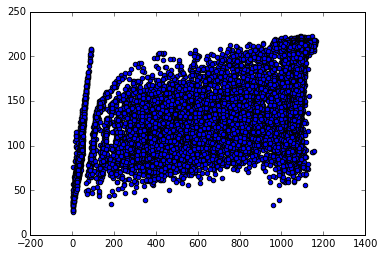

In [51]:
plt.scatter(df_km['rpm'], df_km['motor_temp'])
plt.figure(figsize=(20,10))
plt.show()

### By the above plot we can clearly see that some observations with zero RPM have high motor temperature.which is abnormal.lets use K-means clustering to see any clusters.

In [45]:
clmns = ['rpm', 'motor_voltage','motor_current','motor_temp','inlet_temp']
df_km_std = stats.zscore(df_km[clmns])

kmeans = KMeans(n_clusters=2, random_state=0).fit(df_km_std)
labels = kmeans.labels_

df_km['clusters'] = labels
clmns.extend(['clusters'])

#Lets analyze the clusters
print (df_km[clmns].groupby(['clusters']).mean())

                  rpm  motor_voltage  motor_current  motor_temp  inlet_temp
clusters                                                                   
0         1069.768254     288.604122      44.011019  185.462974   86.978243
1          865.408917     206.992462      30.037887  116.323076   64.130783


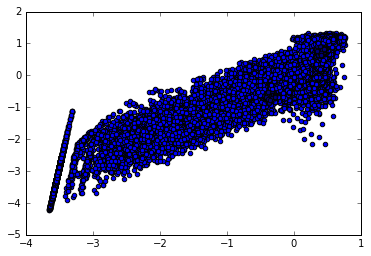

In [48]:
plt.scatter(df_km_std[:, 0], df_km_std[:, 1])

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Here we clearly have two clusters with different averages for each cluster. 
### we can see some similarity between the above plot and scatter plot between rpm and motor temperature.

## Implementing Random Forest for classification to predict the three unique classes for test data.
### Lets see if the RF classifier is doing well.

In [101]:
x = final_feature.drop(['status','timestamp'], axis = 1)
y = final_feature['status']


In [102]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(x, y_enc, test_size=0.33,random_state=1)

In [103]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [104]:
y_pred = clf.predict(X_test)

In [105]:

class_names = list(label_encoder.classes_)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[    0     3     0]
 [    0 17031     0]
 [    0   260    35]]


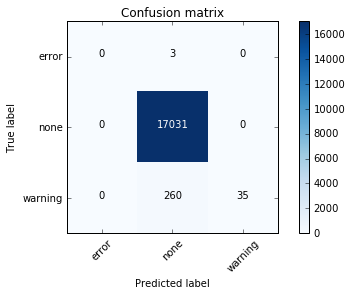

In [106]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names)

## Preparing actual test data for prediction.

In [109]:

alarms_data_test=pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','test')):
    for file in files:
        if file.endswith("alarms.csv") and os.stat(os.path.join(root, file)).st_size > 0:
            alarms_temp_test = pd.read_csv(os.path.join(root, file),header=None)
            alarms_temp_test['unit_id'] = file[4:8]
            alarms_data_test = alarms_data_test.append(alarms_temp_test)
alarms_data_test.columns = ['timestamp', 'status','unit_id']
alarms_data_test['unit_id'] = alarms_data_test['unit_id'].astype('int64')
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].str.split('.').str.get(0)
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].str.split(':').str.get(0)
alarms_data_test['timestamp']=alarms_data_test['timestamp'].str.replace('-','')
alarms_data_test['timestamp']=alarms_data_test['timestamp'].str.replace(' ','.')
alarms_data_test['timestamp'] = alarms_data_test['timestamp'].astype(np.dtype(decimal.Decimal))

In [110]:
rms_data_test = pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(os.getcwd(),'data','test')):
    for file in files:
        if file.endswith("_rms.csv"):
            rms_temp_test = pd.read_csv(os.path.join(root, file))            
            rms_temp_test =clean_rms(rms_temp_test)
            rms_temp_test.index= pd.to_datetime(rms_temp_test['timestamp'])
            rms_temp_test.drop(columns=['timestamp'])
            rms_temp_test=rms_temp_test.resample('3H').mean()
            rms_temp_test['unit_id'] = file[4:8]
            rms_data_test = rms_data_test.append(rms_temp_test)

In [111]:
rms_data_test.reset_index(inplace=True)
rms_data_test = rms_data_test.loc[-rms_data_test['rpm'].isnull()]
dates = rms_data_test['timestamp'].unique()
rms_data_test['unit_id'] = rms_data_test['unit_id'].astype('int64')
rms_data_test['timestamp'] = rms_data_test['timestamp'].astype('str')
rms_data_test['timestamp']= rms_data_test['timestamp'].str.split(':').str.get(0)
rms_data_test['timestamp']=rms_data_test['timestamp'].str.replace('-','')
rms_data_test['timestamp']=rms_data_test['timestamp'].str.replace(' ','.')
rms_data_test['timestamp'] = rms_data_test['timestamp'].astype(np.dtype(decimal.Decimal))



In [112]:
final_feature_test = rms_data_test.merge(alarms_data_test, on=['timestamp', 'unit_id'], how='left')
final_feature_test = final_feature_test.fillna('none')
final_feature_test.head()

,timestamp,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id,status
0,20180501.03,1055.064789,252.798830,36.304095,128.083816,60.254357,20,none
1,20180501.06,1064.598943,241.767332,34.543535,128.057380,67.447624,20,none
2,20180501.09,967.329772,218.293092,31.226371,115.540252,64.068822,20,none
3,20180501.18,1139.620762,232.724501,32.402606,87.344316,52.816108,20,none
4,20180501.21,1068.173605,265.134176,39.220654,140.940384,63.850654,20,none


In [113]:
final_feature_test['status'].unique()

array(['none', 'warning', 'error'], dtype=object)

In [114]:
x = final_feature_test.drop(['status','timestamp'], axis = 1)
y = final_feature_test['status']


,rpm,motor_voltage,motor_current,motor_temp,inlet_temp,unit_id
0,1055.064789,252.798830,36.304095,128.083816,60.254357,20
1,1064.598943,241.767332,34.543535,128.057380,67.447624,20
2,967.329772,218.293092,31.226371,115.540252,64.068822,20
3,1139.620762,232.724501,32.402606,87.344316,52.816108,20
4,1068.173605,265.134176,39.220654,140.940384,63.850654,20
5,1060.025291,269.687101,40.122796,158.819305,81.413736,20
6,1065.755921,265.079202,38.885483,156.635038,83.228116,20
7,1083.479370,255.052715,36.474641,143.481169,75.061336,20
8,1050.500603,243.364207,34.080532,127.719905,69.469885,20
9,1061.135495,246.592711,34.467843,125.666037,65.601918,20


In [115]:
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)
y_pred_test = clf.predict(x)


Confusion matrix, without normalization
[[   0    2    0]
 [   0 6754    0]
 [   0  134    0]]


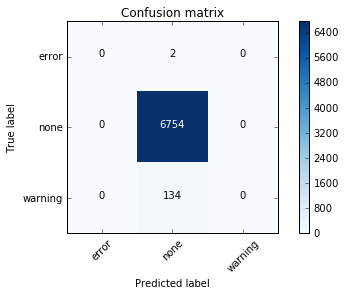

In [119]:
cnf_matrix = confusion_matrix(y_enc, y_pred_test)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=class_names)

# Inference
### As we can see the above Confusion Matrix the prediction is biased towards one class because the number of 'none' class obsevations are high.
### and the predictions are biased towards 'none' class.
### Due to Time constraint I could'nt implement another approch, But, here is the other approch which may yeild better results.

## Approch-2 :-
### We can just train the model with the data which have just warning and error (i.e on the dataset which have just warnings and errors by eliminating the oberservations with none class)
### and predict by doing the same as above we may get a good sensitivity, specificity and AUC curves.

## I thank you guys for giving me this oppurtunity. It was really a fun and challenging task with really good learing experience.